# Import Libraries

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Understanding

In this analysis, I aim to explore the impact of carbon emissions on global temperatures. The focus will be on identifying historical trends, detecting anomalies, and simulating potential future scenarios to understand how changes in CO₂ concentrations influence temperature anomalies.

For this, we will work with two primary datasets:
- **Temperature Data:** Annual temperature anomalies measured in degrees Celsius across decades.
- **CO₂ Data:** Monthly global atmospheric CO₂ concentrations in parts per million (ppm).

In [83]:
temp_data = pd.read_csv('datasets/temperature.csv')
co2_data = pd.read_csv('datasets/carbon_emmission.csv')

In [84]:
temp_data.head()

,ObjectId,Country,ISO2,ISO3,F1961,F1962,F1963,F1964,F1965,F1966,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,-0.113,-0.164,0.847,-0.764,-0.244,0.226,...,1.281,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012
1,2,Albania,AL,ALB,0.627,0.326,0.075,-0.166,-0.388,0.559,...,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518
2,3,Algeria,DZ,DZA,0.164,0.114,0.077,0.250,-0.100,0.433,...,1.192,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688
3,4,American Samoa,AS,ASM,0.079,-0.042,0.169,-0.140,-0.562,0.181,...,1.257,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256
4,5,"Andorra, Principality of",AD,AND,0.736,0.112,-0.752,0.308,-0.490,0.415,...,0.831,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243


In [85]:
co2_data.head()

,ObjectId,Country,Date,Value
0,1,World,1958M03,315.70
1,2,World,1958M04,317.45
2,3,World,1958M05,317.51
3,4,World,1958M06,317.24
4,5,World,1958M07,315.86


In [86]:
temp_data.shape, co2_data.shape

((225, 66), (1570, 4))

In [87]:
co2_data.info(), temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ObjectId  1570 non-null   int64  
 1   Country   1570 non-null   object 
 2   Date      1570 non-null   object 
 3   Value     1570 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 49.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ObjectId  225 non-null    int64  
 1   Country   225 non-null    object 
 2   ISO2      223 non-null    object 
 3   ISO3      225 non-null    object 
 4   F1961     188 non-null    float64
 5   F1962     189 non-null    float64
 6   F1963     188 non-null    float64
 7   F1964     188 non-null    float64
 8   F1965     188 non-null    float64
 9   F1966     192 non-null    float64
 10  F1967     191 non-n

(None, None)

In [88]:
temp_values = temp_data.filter(regex='^F').stack()
co2_values = co2_data['Value']

In [89]:
temp_stats = {'Mean': temp_values.mean(),'Median':temp_values.median(),'Mode':temp_values.var()}
print("Temperature Stats")
temp_stats

Temperature Stats


{'Mean': np.float64(0.5377713483146068),
 'Median': np.float64(0.47),
 'Mode': np.float64(0.4294524831504413)}

In [90]:
co2_stats = {'Mean': co2_values.mean(),'Median':co2_values.median(),'Mode':co2_values.var()}
print("CO2 Stats")
co2_stats

CO2 Stats


{'Mean': np.float64(180.71615286624203),
 'Median': np.float64(313.835),
 'Mode': np.float64(32600.002004693)}

Here, it show that the mean temperature change is around **0.54°C**, with a median of **0.47°C** and variance of **0.43°C**, indicating slight variability in temperature anomalies.

For CO2 concentrations, the mean is **180.72ppm**, the median is **313.84** which is much higher than mean with the variance of **32,600**, which reflects substantial variability in CO2 level over the **1961 to 2022**. This shows the stronger fluctuation in CO2 data compared to temperature changes.

# EDA

## Time Series Analysis
(Analyzed how temperature changes and CO₂ concentrations have evolved overtime and the relationships between them.)

In [91]:
temp_years = temp_data.filter(regex='^F').mean(axis=0)
temp_years.index = temp_years.index.str.replace('F','').astype(int)

co2_data['Year'] = co2_data['Date'].str[:4].astype(int)
co2_yearly = co2_data.groupby('Year')['Value'].mean()
temp_years, co2_yearly

(1961    0.163053
 1962   -0.013476
 1963   -0.006043
 1964   -0.070059
 1965   -0.247027
           ...   
 2018    1.302113
 2019    1.443061
 2020    1.552038
 2021    1.343531
 2022    1.382113
 Length: 62, dtype: float64,
 Year
 1958    315.232000
 1959    172.460455
 1960    158.601667
 1961    158.938333
 1962    159.355000
            ...    
 2020    207.416667
 2021    208.472083
 2022    209.518333
 2023    210.844167
 2024      0.680000
 Name: Value, Length: 67, dtype: float64)

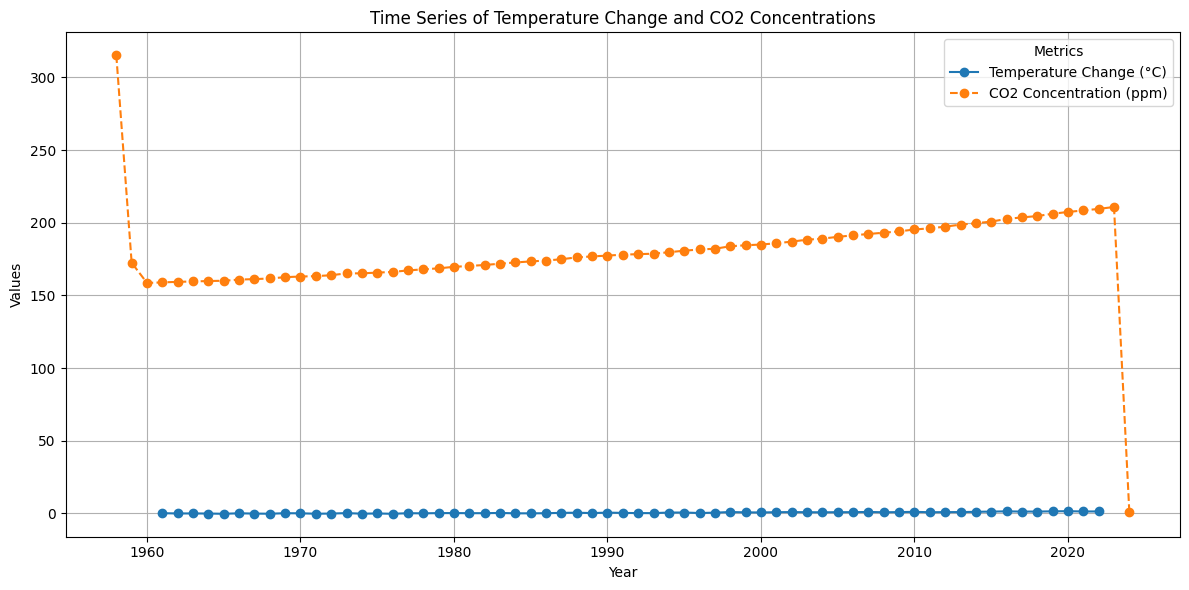

In [92]:
plt.figure(figsize=(12,6))
plt.plot(temp_years.index,temp_years.values,marker='o',label='Temperature Change (°C)')
plt.plot(co2_yearly.index,co2_yearly.values,marker='o',linestyle='--',label='CO2 Concentration (ppm)')
plt.title('Time Series of Temperature Change and CO2 Concentrations')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(title='Metrics')
plt.tight_layout()
plt.grid()
plt.show()

This graph shows, a consistent **increase in CO2 concentrations over the years**, which can cause due the **greenhouse gases**. Simultaneously, there is a **slight upward trend in global temperature change suggests that rising CO2 levels are associated with global warming**. The temporal alignment supports the hypothesis of CO2's significant contribution to temperature increase.

This suggests that while **CO₂ levels are rising rapidly, the temperature impact, though slower, is accumulating steadily and may have long-term consequences**.

In [93]:
grouped_data = pd.DataFrame({
    'Temperature Change': temp_years,
    'CO2 Concentration':co2_yearly
}).dropna()
grouped_data

,Temperature Change,CO2 Concentration
1961,0.163053,158.938333
1962,-0.013476,159.355000
1963,-0.006043,159.580417
1964,-0.070059,159.905833
1965,-0.247027,160.083333
...,...,...
2018,1.302113,204.598750
2019,1.443061,206.183333
2020,1.552038,207.416667
2021,1.343531,208.472083


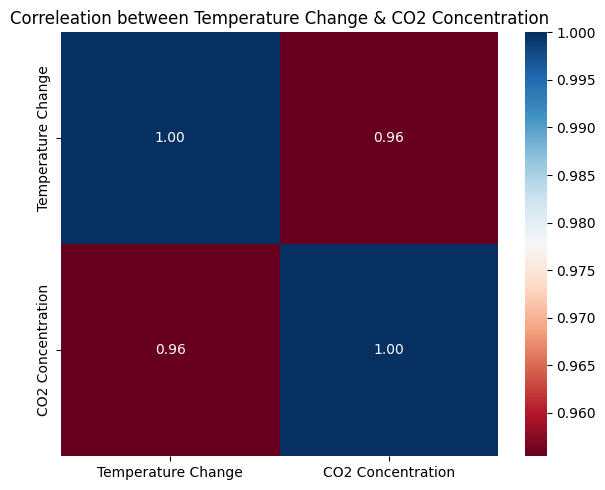

In [94]:
colors = ["blue", "red"]
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

plt.figure(figsize=(6,5))
sns.heatmap(grouped_data.corr(),annot=True,fmt='.2f',cmap='RdBu')
plt.title('Correleation between Temperature Change & CO2 Concentration')
plt.tight_layout()
plt.show()

This heatmap reveals a very strong positive correaltion **(0.96)** between Temperature Change and CO2 Concentrations.

This correlation suggest that, **higher the CO2 levels are closely linked with the increasing overall global temperatures, which highlights the importance of carbon emissions to ease the climate change.**

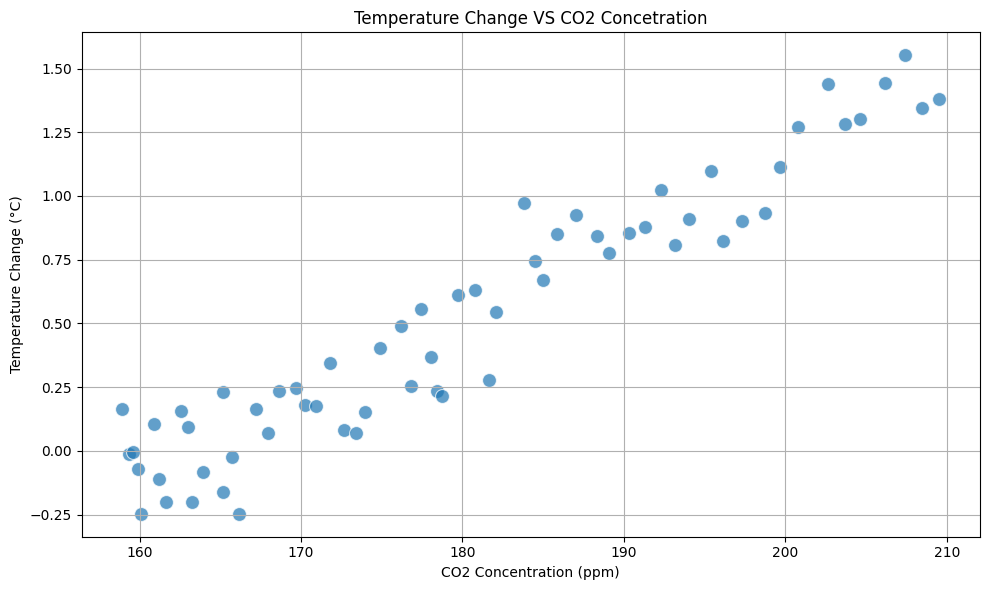

In [95]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='CO2 Concentration',y='Temperature Change',data=grouped_data,s=100,alpha=0.7)
plt.title("Temperature Change VS CO2 Concetration")
plt.xlabel('CO2 Concentration (ppm)')
plt.ylabel('Temperature Change (°C)')
plt.grid()
plt.tight_layout()
plt.show()

The scatter plot also shows a clear linear trend among Temperature Change and CO2 Concentration.

This proofs that there is **direct relationship between CO2 emission and global warming, which provide further support for policies targeting reductions in Carbon Emission to tackle the climate impacts**.

In [107]:
co2_data['Month'] = co2_data['Date'].str[-2:].astype(int)
co2_monthly = co2_data.groupby(by='Month')['Value'].mean()
co2_monthly

Month
1     178.155038
2     181.296202
3     181.359313
4     182.014275
5     182.307405
6     182.025191
7     181.252061
8     180.237252
9     179.461374
10    179.490763
11    180.168473
12    180.835344
Name: Value, dtype: float64

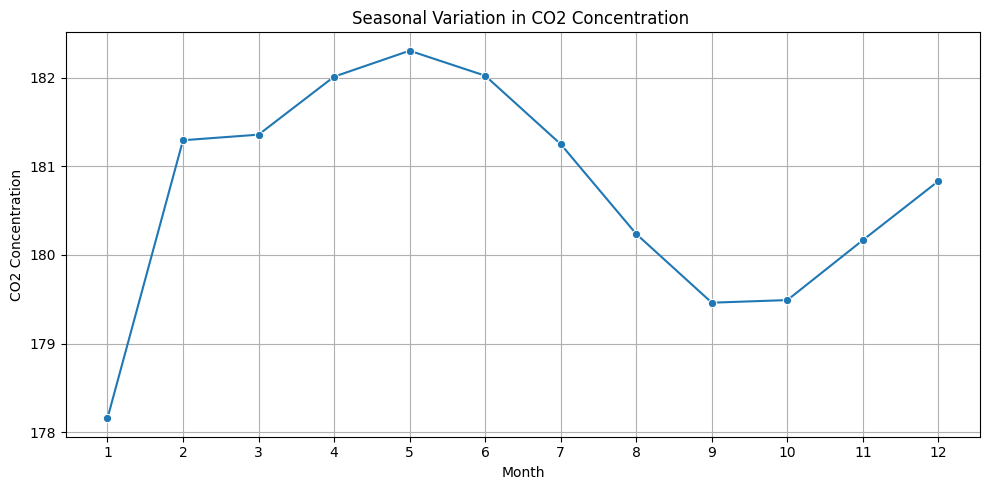

In [109]:
plt.figure(figsize=(10,5))
sns.lineplot(x=co2_monthly.index,y=co2_monthly.values,marker='o')
plt.xlabel('Month')
plt.ylabel('CO2 Concentration')
plt.title('Seasonal Variation in CO2 Concentration ')
plt.grid()
plt.xticks(ticks=range(1,13))
plt.tight_layout()
plt.show()

This graph highlights the seasonal changes in CO2 Concentration which **peak during late spring and early summer (around May)** and reach the **lowest levels in fall (around September)**. 

These variations are likely due to natural processes such plant photosynthesis, which **absorbs CO2 during the growing season** and respiration, which **releases CO2 in the off-season**. This shows us the role of natural carbon sinks in moderating atmospheric CO2 levels

## Correlation and Causality Analysis
(To quantify the relationship between CO₂ and temperature anomalies.)

In [121]:
pearson_corr,_ = pearsonr(grouped_data['CO2 Concentration'],grouped_data['Temperature Change'])
spearman_corr,_ = spearmanr(grouped_data['CO2 Concentration'],grouped_data['Temperature Change'])
print(f"Person Correlation:{round(float(pearson_corr),3)}\nSpearman Correlation:{round(float(spearman_corr),3)}")

Person Correlation:0.955
Spearman Correlation:0.938


In [133]:
# granger causality test
granger_data = grouped_data.diff().dropna() # it make data stationary
granger_results = grangercausalitytests(granger_data,maxlag=3, verbose=False)
for lag, results in granger_results.items():
    print(f"Lag {lag}:",round(float(results[0]['ssr_chi2test'][1]),4))

Lag 1: 0.0617
Lag 2: 0.6754
Lag 3: 0.2994


C:\Users\deepa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


**Pearson Correlation (0.955)** indicates a very strong linear relationship between CO2 concentrations and temperature changes.

**Spearman Correlation (0.938)** indicates a very strong monotonic relationship between CO2 concentrations and temperature changes.

**Granger Causality Test**:
- **Lag 1: 0.0617** (slightly above from 0.05, suggest weak proof for causality)
- **Lag 2: 0.6754** (> 0.05, suggest no proof for causality)
- **Lag 3: 0.2994** (> 0.05, suggest no proof for causality)

## Lagged Effects Analysis
(Analyzed whether CO₂ concentrations from previous years (lagged values) influence current temperature anomalies.)

In [139]:
# Creating columns for lagged CO2 data 
grouped_data['CO2 Lag1'] = grouped_data['CO2 Concentration'].shift(1)
grouped_data['CO2 Lag2'] = grouped_data['CO2 Concentration'].shift(2)
grouped_data['CO2 Lag3'] = grouped_data['CO2 Concentration'].shift(3)

lagged_data = grouped_data.dropna() # removing null values
lagged_data.head()

,Temperature Change,CO2 Concentration,CO2 Lag1,CO2 Lag2,CO2 Lag3
1964,-0.070059,159.905833,159.580417,159.355000,158.938333
1965,-0.247027,160.083333,159.905833,159.580417,159.355000
1966,0.105505,160.892083,160.083333,159.905833,159.580417
1967,-0.110832,161.216667,160.892083,160.083333,159.905833
1968,-0.199110,161.659583,161.216667,160.892083,160.083333


In [137]:
X = lagged_data[['CO2 Concentration','CO2 Lag1','CO2 Lag2','CO2 Lag3']]
y = lagged_data['Temperature Change']
X.head(), y.head()

(      CO2 Concentration    CO2 Lag1    CO2 Lag2    CO2 Lag3
 1964         159.905833  159.580417  159.355000  158.938333
 1965         160.083333  159.905833  159.580417  159.355000
 1966         160.892083  160.083333  159.905833  159.580417
 1967         161.216667  160.892083  160.083333  159.905833
 1968         161.659583  161.216667  160.892083  160.083333,
 1964   -0.070059
 1965   -0.247027
 1966    0.105505
 1967   -0.110832
 1968   -0.199110
 Name: Temperature Change, dtype: float64)

In [140]:
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Temperature Change   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     252.5
Date:                Tue, 27 May 2025   Prob (F-statistic):           2.97e-34
Time:                        11:33:04   Log-Likelihood:                 45.098
No. Observations:                  59   AIC:                            -80.20
Df Residuals:                      54   BIC:                            -69.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.7980      0.317    -15.137      0.000      -5.434      -4.163
CO2 Concentration     0.3245      0.055      5.942      0.000       0.215       0.434
CO2 Lag1             -0.2962      0.068     -4.361      0.000      -0.432      -0.160
CO2 Lag2              0.0104      0.068      0.153      0.879      -0.126       0.146
CO2 Lag3             -0.0107      0.056     -0.191      0.849      -0.123       0.101
==============================================================================
Omnibus:                        2.369   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.077
Skew:                          -0.457   Prob(JB):                        0.354
Kurtosis:                       2.902   Cond. No.                     7.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The OLS regression results indicate a strong relationship between CO2 Concentration and Temperature change.
- R2 value of **0.949**, meanning **94.9%** of the variance in temperature change is explained by the model.
- The **coefficient for CO2 Concentration (0.3245)** is statstically significant **(p<0.05)**, which indicate a postive association between CO2 levels and temperature change.

# Modeling
(Build a LR model to simulate how changes in CO₂ concentrations might influence global temperatures.)

In [148]:
# Prepared dependent and independent data
X = grouped_data[['CO2 Concentration']].values
y = grouped_data['Temperature Change'].values
X,y

(array([[158.93833333],
        [159.355     ],
        [159.58041667],
        [159.90583333],
        [160.08333333],
        [160.89208333],
        [161.21666667],
        [161.65958333],
        [162.555     ],
        [163.00375   ],
        [163.25666667],
        [163.90291667],
        [165.17791667],
        [165.17375   ],
        [165.70708333],
        [166.14875   ],
        [167.19666667],
        [167.9425    ],
        [168.62958333],
        [169.66708333],
        [170.26041667],
        [170.93916667],
        [171.82166667],
        [172.68333333],
        [173.39125   ],
        [173.98625   ],
        [174.90125   ],
        [176.18541667],
        [176.8175    ],
        [177.40333333],
        [178.02833333],
        [178.39166667],
        [178.70125   ],
        [179.72375   ],
        [180.76458333],
        [181.61791667],
        [182.095     ],
        [183.8275    ],
        [184.50166667],
        [185.0125    ],
        [185.87708333],
        [187.013

In [252]:
# Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [253]:
# Model building
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

In [254]:
y_pred = LR.predict(X_test)

In [255]:
# Evaluation of Linear Regression model
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2,rmse,mae

(0.9098072391296598, np.float64(0.15442595767344625), 0.1284168149023104)

The linear regression model demonstrates strong predictive performance:
- **R² (0.91):**  The model explains approx. **91%** of the variance in the target variable, indicating a good fit.
- **RMSE (0.15) and MAE (0.13):** Prediction errors are relatively low, suggesting the **model is accurate and consistent**.

In [256]:
# funtion to stimulate "what-if" scenarios
def simulate_temperature_change(co2_percent_change):
    # calculate new CO2 Concentration
    current_mean_co2 = grouped_data['CO2 Concentration'].mean()
    new_co2 = current_mean_co2 * (1 + co2_percent_change / 100)

    # predict temperature change
    pred_temp = LR.predict([[new_co2]])
    return pred_temp

In [257]:
# simulating scenarios
scenarios = {
    "Increase CO₂ by 10%": float(simulate_temperature_change(10)[0]),
    "Decrease CO₂ by 10%": float(simulate_temperature_change(-10)[0]),
    "Increase CO₂ by 20%": float(simulate_temperature_change(20)[0]),
    "Decrease CO₂ by 20%": float(simulate_temperature_change(-20)[0]),
}
scenarios

{'Increase CO₂ by 10%': 1.0967991508855626,
 'Decrease CO₂ by 10%': -0.09590685859445003,
 'Increase CO₂ by 20%': 1.693152155625567,
 'Decrease CO₂ by 20%': -0.6922598633344546}

Here, our model shows that **10% increase in CO2 results in a notable rise in temperature anomalies**, which demonstrated the sentivity of global temperatures to CO2 levels. Conversely, a **10% - 20% reduction in CO2 could lead to significant cooling effects**, which will potentially reverse some warming trends.

# Conclusion

By analysing the temperature and carbon emission data. Here are some key highlights of the analysis:
- There is **strong positive** correlation between rising **CO2 Concentration** and **Global temperature** Anomalies.
- CO2 levels are **increasing at a faster rate** than temperature changes.
- Time Series reveals a clear trends of **escalating emission driving temperature increases**, while seasonal variation suggest the moderate role of natural carbon sinks.
- Lagged effects suggest that **current CO2 levels have most significant impact on temperature changes**, with very small influence from the past emissions.
- Simulating "what-if" scenarios to demonstrate the sensitivity of Global temperature to CO2 levels, which shows that **even modest reduction in emissions could significantly ease global warming**.